# Initial visualization of CYGNSS watermask
## Environments and packages
Chose to use xarray package, not netCDF4, to read the data, so I can view, manipulate, and analyze the data within xarray. I could not use a custom conda environment within Savio Jupyter notebooks, so I am using the base environment with xarray `pip install`ed in my home directory.

Use xarray v0.18.0, but cannot use a conda environment to set this because I don't understand Savio.

## Directory structure
I am reading CYGNSS watermasks from Cynthia's Savio scratch account. There is a 0.01$^\circ$ format and a 0.5$^\circ$ format. For my purposes, I want to always use the 'with_lakes' version. The 0.5$^\circ$ version is a single .nc file while the 0.01$^\circ$ version is a separate .nc file for each month.

# Reading Data 0.5$^\circ$
## Data description 0.5$^\circ$
- Monthly data from 2018-08 to 2022-04 (inclusive)
- xarray indexing order: [lat,lon,time]
- single .nc file

In [69]:
# !pip install xarray --user
import sys
# sys.path.append('/global/home/users/ann_scheliga/.local/lib/python3.7/site-packages/xarray')
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

In [70]:
cygnss_filename = 'CYGNSS_watermask_0_5_with_lakes.nc'
cygnss_filepath = '/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/WetCHARTs_size_0_5_deg/'

In [71]:
cygnss_raw = xr.open_dataset(cygnss_filepath+cygnss_filename, decode_times=False)
fw=cygnss_raw['fw']
fw

<xarray.DataArray 'fw' (lat: 151, lon: 721, time: 57)>
[6205647 values with dtype=float32]
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 52.0 53.0 54.0 55.0 56.0
  * lat      (lat) float32 -37.5 -37.0 -36.5 -36.0 -35.5 ... 36.0 36.5 37.0 37.5
  * lon      (lon) float32 -180.0 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
Attributes:
    long_name:  Monthly fractional surface water (0-100)
    units:      percent water

## Sample map for a single time

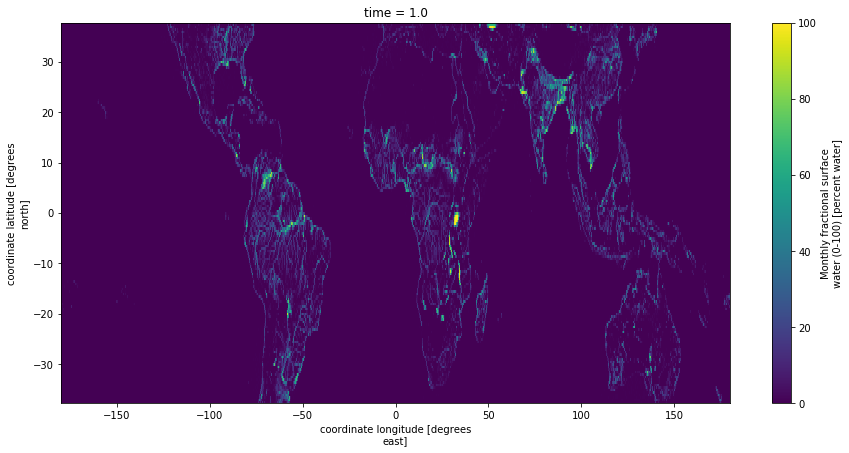

In [4]:
sep2018 = fw[:,:,1]
sep2018.plot(figsize=(15,7))

## Sample time series for a single pixel

In [5]:
merowe = (18.68 , 32.06)
indirasagar = (22.18,76.6)

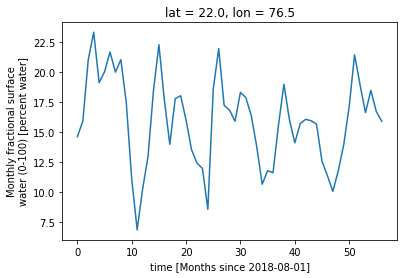

In [6]:
coords_i = (22.18,76.6) # (lat,lon) 
fw.sel(lat=coords_i[0],lon=coords_i[1],method='nearest').plot()

## Time coordinate mainpulations

# Reading data 0.01$^\circ$

## Data loading
Successfully made loading functions to read and combine multiple months of data for a given bounding box.
## Data description 0.01$^\circ$
- native resolution
- Monthly data from 2018-08 to 2022-04 (inclusive)
- one .nc file per month

In [29]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray
import os

In [43]:
cygnss_filepath = '/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/Native_size_0_01_deg/With_lakes/'
cygnss_filenames = os.listdir(cygnss_filepath)
cygnss_filenames.sort()

In [4]:
test_1month = xr.open_dataset(cygnss_filepath+cygnss_filenames[0], decode_times=False)
fw=test_1month['Watermask']
fw

<xarray.DataArray 'Watermask' (lat: 7481, lon: 36001)>
[269323481 values with dtype=int8]
Coordinates:
  * lat      (lat) float32 -37.4 -37.39 -37.38 -37.37 ... 37.37 37.38 37.39 37.4
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:  UCBerkeley_RW_CYGNSS-based watermask for 2019_06
    units:      Land = 1, Surface water = 2, Ocean = 3, No data = 4
    comments:   Values ranges from 1-4, where Land = 1, Surface water = 2, Oc...

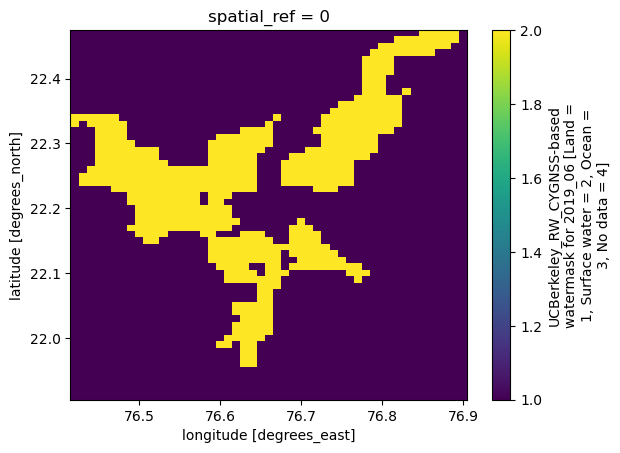

In [5]:
test_rxr = fw.rio.write_crs(4326)
test_rxr.rio.set_spatial_dims('lon','lat',inplace=True)
test_boxclip = test_rxr.rio.clip_box(76.42467457600003, 21.907250000000033, 76.90174206500012, 22.4733543750001)
test_boxclip.plot()

In [6]:
test_bbox = (76.42467457600003, 21.907250000000033, 76.90174206500012, 22.4733543750001)

In [14]:
def read_CYGNSS_01_1month(filename,
    bbox_vals,
    filepath='/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/Native_size_0_01_deg/With_lakes/'
    ):
    global_xrDS = xr.open_dataset(filepath+filename, decode_times=False)
    global_rxr = global_xrDS['Watermask'].rio.write_crs(4326)
    del global_xrDS
    global_rxr.rio.set_spatial_dims('lon','lat',inplace=True)
    clipped_rxr = global_rxr.rio.clip_box(*bbox_vals)
    del global_rxr
    return clipped_rxr

In [81]:
def read_CYGNSS_all_months(
    bbox_vals,
    filepath='/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/Native_size_0_01_deg/With_lakes/'
    ):
    filenames = os.listdir(filepath)
    filenames.sort()
    list_of_xr = [read_CYGNSS_01_1month(filename,test_bbox) for filename in filenames]
    time_idx = np.arange(len(filenames))
    cygnss_allmonths_xr = xr.concat(list_of_xr,pd.Index(time_idx , name='time'),combine_attrs="drop_conflicts")
    return cygnss_allmonths_xr

In [83]:
test_allmonths = read_CYGNSS_all_months(test_bbox)

In [15]:
def CYGNSS_1month_plot(filename,
    bbox_vals,
    filepath='/global/scratch/users/cgerlein/fc_ecohydrology_scratch/CYGNSS/Data/CYGNSS_L1_v3_1_data_products/Monthly_maps_watermasks_glob_netCDF/Native_size_0_01_deg/With_lakes/'
    ):
    clipped_rxr = read_CYGNSS_01_1month(filename,bbox_vals,filepath)
    clipped_rxr.plot()
    return clipped_rxr

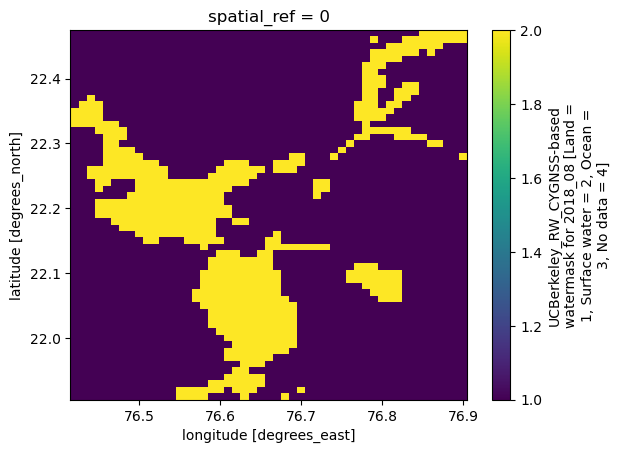

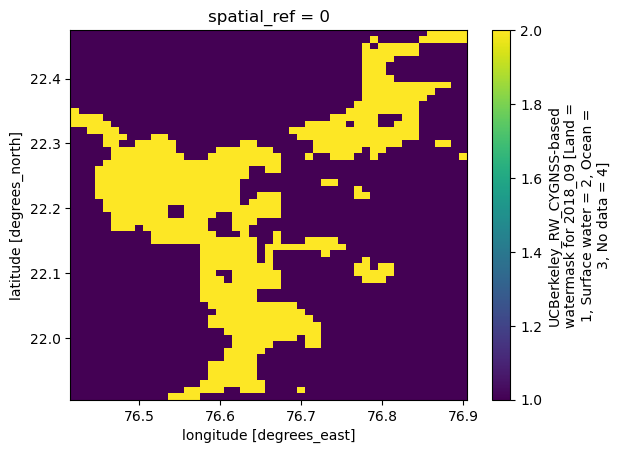

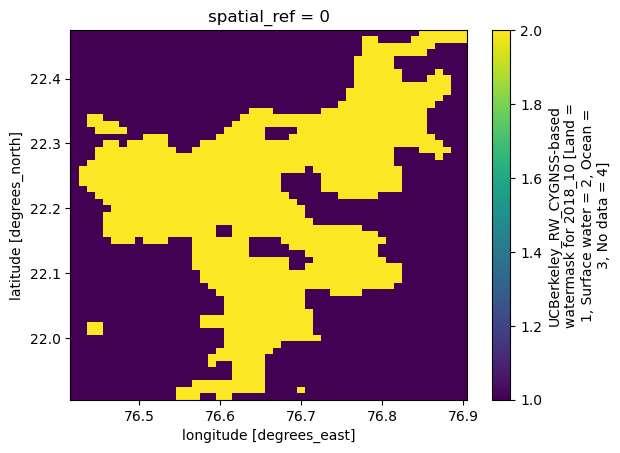

In [44]:
small_list = cygnss_filenames[:3]

# fig , ax = plt.subplots()
for filename in small_list:
    plt.figure()
    CYGNSS_1month_plot(filename,test_bbox)